![logo](https://www.tec.ac.cr/sites/default/files/media/branding/logo-tec.png "TEC")

# Big Data, Programa de Ciencia de los Datos
## Tarea #3

* **Esteban Sáenz Villalobos** (**esaenz7@gmail.com**)
* Entrega: 29 de agosto 2021, 23:00.
* Observaciones: Trabajo elaborado desde Google Colab. Ejecutar cada celda de código de forma secuencial.


## Objetivo
Ejecutar el proceso de extracción de datos y entrenamiento de un modelo en Apache Spark de principio a fin.

## Resultados esperados para esta asignación
Para esta asignación los estudiantes deberán entregar un Jupyter Notebook donde se entrene un modelo de clasificación binaria, basada en algún conjunto de datos de su escogencia (e.g. conjuntos de kaggle).

El notebook deberá ser autocontenido en su ejecución y análisis de resultados, utilizando una instancia de postgresql como apoyo, ejecutada a través de un contenedor, como hemos hecho hasta el momento. El notebook deberá ejecutarse desde un contenedor Docker. Se espera que los estudiantes se basen en infraestructura Spark y no en código secuencial hecho en Python. El uso del framework será parte de lo evaluado en la asignación.

## Consideraciones generales

Para obtener el puntaje de cada uno de los rubros los estudiantes deberán mostrar suficiente información en la salida del Jupyter Notebook para demostrar que se cumple con lo pedido.
Como el Jupyter Notebook deberá correrse sobre un contenedor, deberá entregarse un archivo comprimido que contenga el análogo al repositorio con un Dockerfile, además de un PDF con todas las instrucciones necesarias para poder ejecutar exitosamente el código del Notebook.

---

## Código para Google Colab únicamente

In [1]:
# '''
# Instalación de PySpark en Colab
# '''

# from IPython.display import Javascript
# ##@title spark-submit programaestudiante.py { vertical-output: true, form-width: "50%", display-mode: "both" }
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# import requests, os
# from bs4 import BeautifulSoup
# #obtener las versiones de spark e instalar la última disponile
# soup = BeautifulSoup(requests.get('https://downloads.apache.org/spark/').text)
# link_files = []
# [link_files.append(link.get('href')) for link in soup.find_all('a')]
# spark_link = [x for x in link_files if 'spark' in x]
# ver_spark = spark_link[-1][:-1]
# os.system(f"wget -q https://www-us.apache.org/dist/spark/{ver_spark}/{ver_spark}-bin-hadoop3.2.tgz")
# os.system(f"tar xf {ver_spark}-bin-hadoop2.7.tgz")
# #instalar pyspark
# !pip install -q pyspark
# !pip --version
# !pyspark --version
# !pip install -q findspark

<IPython.core.display.Javascript object>

     |████████████████████████████████| 212.4 MB 60 kB/s 
     |████████████████████████████████| 198 kB 70.7 MB/s 
pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 11.0.11
Branch HEAD
Compiled by user centos on 2021-05-24T04:27:48Z
Revision de351e30a90dd988b133b3d00fa6218bfcaba8b8
Url https://github.com/apache/spark
Type --help for more information.


## Datos de entrada (5 puntos)

Los estudiantes podrán seleccionar un conjunto de datos de su preferencia. Se espera que se provea una descripción de los datos, donde se detalle cuál es el dominio del problema y una descripción de los diferentes atributos en el conjunto. Debe incluir explícitamente cuál es la variable de predicción a utilizar.


In [2]:
'''
Carga de datos, librerías, parámetros y sesión spark
'''

#instalación de paquetes adicionales
# !pip3 install -q scikit-learn scipy matplotlib
# !pip install -q handyspark
!pip3 install -q gdown

#descargar del archivo fuente
# !gdown https://drive.google.com/uc?id=1RnIhzhH0yBNVjneB9b1X37HmtEKrb_20
!gdown https://drive.google.com/uc?id=1JwoK3CGJeS25SEl11hbIJDDFCO8RkOkn

#librerías necesarias
import sys, os, glob, datetime as dt, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pyspark.sql import SparkSession, functions as F, window as W, DataFrame as DF
from pyspark.sql.types import (DateType, IntegerType, FloatType, DoubleType, LongType, StringType, StructField, StructType, TimestampType)
from pyspark.ml import functions as mlF, Pipeline as pipe
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, HashingTF, Tokenizer, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, DecisionTreeClassificationModel, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from functools import reduce
# from handyspark import *

import findspark
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

#variables postgres
# args = sys.argv
# print(args)
#estos parámetros corresponden a la instancia de postgres dentro del ambiente de docker que se adjunta al trabajo
host = '10.7.84.102'
port = '5432'
user = 'postgres'
password = 'testPassword'

#sesión de spark
spark = SparkSession.builder\
  .master("local")\
  .appName("App#1")\
  .config('spark.ui.port', '4050')\
  .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
  .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
  .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

#funciones personalizadas
#función columnas-vector
def cols2vec(dfin, inputcols=[], outputcol='features', label='class', lab_alias='class', print=False):
  try:
    assy = VectorAssembler(inputCols=inputcols, outputCol=outputcol)
    dfout = assy.transform(dfin)
    if lab_alias:
      dfout = dfout.select([outputcol, F.col(label).alias(lab_alias)])
    else:
      dfout = dfout.select([outputcol])
    if print: dfout.show(truncate=False)
    return dfout
  except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    print(exc_type, os.path.split(exc_tb.tb_frame.f_code.co_filename)[1], exc_tb.tb_lineno, exc_obj)

#función vector-columnas
def vec2cols(dfin, inputcol='features', outputcols=[], label='class', lab_alias='class', print=False, prediction=None):
  try:
    if lab_alias:
      if prediction:
        dfout = dfin.select(inputcol, label, prediction).withColumn('temp', mlF.vector_to_array(inputcol)) \
        .select([F.col('temp')[i].alias(outputcols[i]) for i in range(len(outputcols))] + [F.col(label).alias(lab_alias)] + [F.col(prediction)])
      else:
        dfout = dfin.select(inputcol, label).withColumn('temp', mlF.vector_to_array(inputcol)) \
        .select([F.col('temp')[i].alias(outputcols[i]) for i in range(len(outputcols))] + [F.col(label).alias(lab_alias)])
    else:
      dfout = dfin.select(inputcol, label).withColumn('temp', mlF.vector_to_array(inputcol)) \
      .select([F.col('temp')[i].alias(outputcols[i]) for i in range(len(outputcols))])
    if print: dfout.show(truncate=False)
    return dfout
  except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    print(exc_type, os.path.split(exc_tb.tb_frame.f_code.co_filename)[1], exc_tb.tb_lineno, exc_obj)

#función de graficación ROC
def plot_roc(df=None, metric=None, v=1):
  try:
    getval = lambda x: [i[0] for i in x]
    getroc = lambda x,y: roc_curve(np.array(getval(x)), np.array(getval(y))[:,[1]].reshape(-1), pos_label=1)
    fpr, tpr, thresholds = getroc(df.select(['label']).collect(), df.select(['probability']).collect())
    roc_auc = auc(fpr, tpr)
    if v==1:
      plt.figure(figsize=(5,5))
      plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0]), plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
      plt.title('ROC Curve'), plt.legend(loc="lower right")
      plt.show()
      return (roc_auc, fpr, tpr, thresholds)
    else:
      fig, axs = plt.subplots(1, 2, figsize=(12, 4))
      metric.plot_roc_curve(ax=axs[0])
      metric.plot_pr_curve(ax=axs[1])
      plt.show()
      return (roc_auc, fpr, tpr, thresholds)
  except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    print(exc_type, os.path.split(exc_tb.tb_frame.f_code.co_filename)[1], exc_tb.tb_lineno, exc_obj)

Downloading...
From: https://drive.google.com/uc?id=1JwoK3CGJeS25SEl11hbIJDDFCO8RkOkn
To: /content/Star39552_balanced.csv
100% 1.53M/1.53M [00:00<00:00, 7.13MB/s]


## Descripción general del conjunto de datos

### **Star Dataset: Clasificación estelar**.

### Fuente

  * [Kaggle](https://www.kaggle.com/vinesmsuic/star-categorization-giants-and-dw).

### Objetivo predictivo

  * Clasificación binaria para determinar si una estrella es enana o gigante.

### Dominio de problema

  * La clasificación estelar utiliza los datos espectrales de las estrellas para clasificarlas en diferentes categorías. El sistema de clasificación estelar moderno se conoce como el sistema de clasificación Morgan-Keenan (MK), utiliza el antiguo sistema de clasificación HR para clasificar las estrellas según su cromaticidad y utiliza números romanos para clasificar el tamaño de la estrella.

### Atributos del conjunto

  * En este conjunto de datos se utilizarán las siguientes características:

    * Vmag: Magnitud visual aparente de la estrella.
    * Plx: Distancia entre la estrella y la tierra.
    * e_Plx: Error estándar de 'Plx'.
    * B-V: Índice de color B-V.
    * SpType: Tipo espectral.
    * Amag: Magnitud absoluta de la estrella.

### Variable de predicción

  * Class: Indica si la estrella es enana (0) o gigante (1).

---

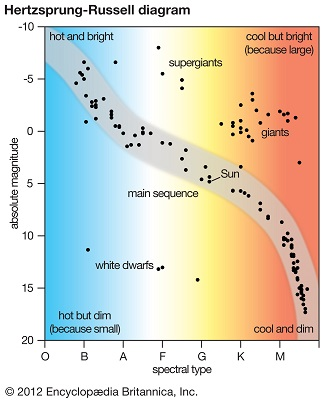

## Preprocesamiento de datos

Similar al protocolo visto en clase, la primera fase deberá leer y ajustar los datos previo a la fase de entrenamiento. Se espera que los estudiantes cumplan con:

  * Cargado y limpieza de datos de archivo de entrada CSV. Esto implica la definición del "schema" y muestras en el notebook que los datos se han cargado exitosamente (5 puntos).
  * Gráficos y estadísticas descriptivas previo al entrenamiento. Se espera que los estudiantes muestren estadísticas descriptivas, correlaciones, etc. Ésto con el fin de entender el conjunto de datos (10 puntos).
  * Normalización / Estandarización. Los estudiantes deberán seleccionar alguna estrategia para mitigar los problemas de escala que pueden tener las diferentes columnas del modelo (10 puntos).
  * Escritura a base de datos. Una vez que los datos hayan sido depurados se espera que los estudiantes escriban a una tabla llamada tarea3 (con overwrite) el conjunto de datos que se utilizará como base para el entrenamiento. Los estudiantes deberán documentar en detalle cualquier instrucción necesaria para poder calificar esta sección. Los datos escritos en la base de datos no podrán estar almacenados en forma de vector. Deben ser extraídos a columnas individuales (10 puntos).


In [3]:
#dataframe inicial
#lectura de archivo csv
df_stars = spark \
  .read \
  .format('csv') \
  .option('path', 'Star39552_balanced.csv') \
  .option('header', True) \
  .schema(StructType([
          StructField("vmag", FloatType()),
          StructField("plx", FloatType()),
          StructField("eplx", FloatType()),
          StructField("bv", FloatType()),
          StructField("sptype", StringType()),
          StructField("amag", FloatType()),
          StructField("class", IntegerType())])) \
  .load()
print('Dataframe incial')
df_stars.show(truncate=False)
df_stars.printSchema()

#subconjunto de interés
df1 = df_stars
cols = ['vmag', 'plx', 'bv', 'amag', 'class'] #selección de variables de interés
df1 = df_stars.select(cols)
print('Subconjunto de interés')
df1.show(truncate=False)

Dataframe incial
+----+-----+----+------+----------+----------+-----+
|vmag|plx  |eplx|bv    |sptype    |amag      |class|
+----+-----+----+------+----------+----------+-----+
|10.0|31.66|6.19|1.213 |K7V       |22.502556 |1    |
|8.26|3.21 |1.0 |1.13  |K0III     |15.792525 |0    |
|8.27|12.75|1.06|0.596 |F9V       |18.797552 |1    |
|6.54|5.23 |0.76|1.189 |K1III     |15.132508 |0    |
|8.52|0.96 |0.72|0.173 |B8V       |13.431356 |1    |
|6.09|6.02 |0.95|0.04  |B8IVn     |14.987983 |1    |
|7.94|5.36 |0.61|1.066 |K0III     |16.585825 |0    |
|6.81|13.13|1.04|1.03  |K1III     |17.401323 |0    |
|7.68|0.66 |0.62|0.013 |B2V:e     |11.7777195|1    |
|8.78|8.26 |1.14|0.682 |G2IV      |18.364899 |1    |
|7.97|9.02 |2.5 |0.556 |F7V       |17.746033 |1    |
|5.18|2.52 |0.55|-0.274|B1IV/V    |12.187002 |1    |
|8.86|2.49 |1.27|1.063 |K0III     |15.840996 |0    |
|8.73|2.29 |1.08|-0.035|B2Vnne    |15.529177 |1    |
|7.59|6.13 |0.9 |0.043 |A0V       |16.527302 |1    |
|8.34|6.04 |1.85|0.375 |A9V  

In [4]:
#descripción del dataframe
print('Momentos estadísticos')
df1.describe().show()
print('Balance de clases objetivo')
dftarget = df1.groupBy('class').count()
dftarget = dftarget.withColumn('%', dftarget['count'] * 100 / df1.count()).show()
print('Valores nulos')
df1.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in df1.columns]).show()

Momentos estadísticos
+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|              vmag|               plx|                bv|             amag|             class|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|             39552|             39552|             39552|            39552|             39552|
|   mean|  7.92130941586135| 7.117377630728088|0.7443357603284035|16.05068687656382|               0.5|
| stddev|1.3088569325465211|12.446291035739133|0.5139870264397692|2.443937340236048|0.5000063209127419|
|    min|             -0.62|            -27.84|              -0.4|       -0.3499999|                 0|
|    max|             12.85|            772.33|              3.44|        30.449015|                 1|
+-------+------------------+------------------+------------------+-----------------+------------------+

Balance de clases objetivo
+-----+-----+-

In [5]:
#ingeniería de características
'''
Determinaciones:
+ no existen valores nulos o impropios en las columnas de interés
+ las clases se encuentran defindas y balanceadas
+ las escalas o magnitudes de los valores difieren entre algunas columnas
'''

#vectorización
dfvec = cols2vec(df1, inputcols=['vmag', 'plx', 'bv', 'amag'], outputcol='features', label='class', lab_alias='class', print=True)

#estandarización
standard_scaler = StandardScaler(inputCol='features', outputCol='scaled', withStd=True, withMean=True).fit(dfvec)
dfscaled = standard_scaler.transform(dfvec)
dfscaled = dfscaled.select(['scaled', 'class'])
dfscaled.show(truncate=False)

#análisis PCA (extra-opcional)
pca = PCA(k=3, inputCol='scaled', outputCol='pca').fit(dfscaled)
dfpca = pca.transform(dfscaled)
dfpca = dfpca.select(['pca','class'])
dfpca.show(truncate=False)
print('PCA, varianza explicada: ', pca.explainedVariance.toArray())

+------------------------------------------------------------------------------+-----+
|features                                                                      |class|
+------------------------------------------------------------------------------+-----+
|[10.0,31.65999984741211,1.2130000591278076,22.50255584716797]                 |1    |
|[8.260000228881836,3.2100000381469727,1.1299999952316284,15.792525291442871]  |0    |
|[8.270000457763672,12.75,0.5960000157356262,18.79755210876465]                |1    |
|[6.539999961853027,5.230000019073486,1.1890000104904175,15.132508277893066]   |0    |
|[8.520000457763672,0.9599999785423279,0.17299999296665192,13.431356430053711] |1    |
|[6.090000152587891,6.019999980926514,0.03999999910593033,14.987982749938965]  |1    |
|[7.940000057220459,5.360000133514404,1.065999984741211,16.585824966430664]    |0    |
|[6.809999942779541,13.130000114440918,1.0299999713897705,17.401323318481445]  |0    |
|[7.679999828338623,0.6600000262260437,0.01

Mapa de calor


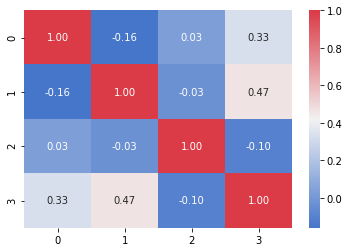


Gráficos de correlación
Variables estandarizadas


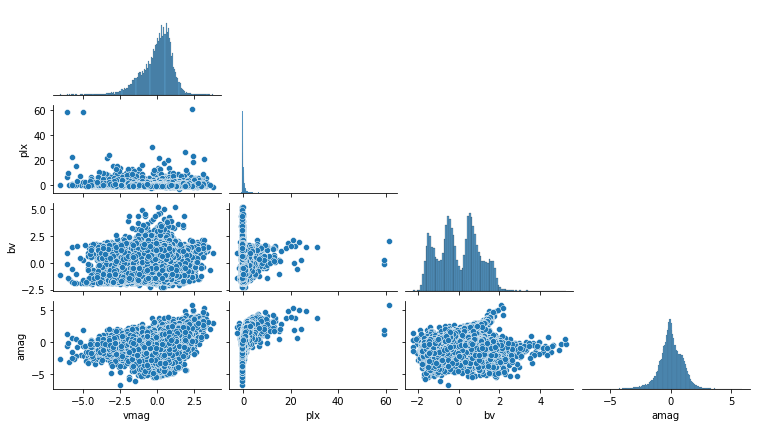

Componentes principales


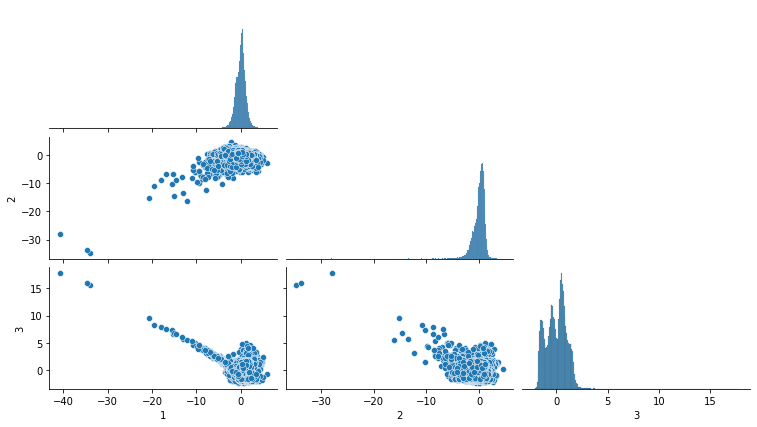

In [6]:
#visualizaciones del dataframe
#correlación
print('Mapa de calor')
pearson_matrix = Correlation.corr(dfscaled, 'scaled', method='pearson').collect()[0][0]
sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap=sns.diverging_palette(255,10,as_cmap=True))
plt.show()
print('\nGráficos de correlación')
print('Variables estandarizadas')
sns.pairplot(vec2cols(dfscaled, inputcol='scaled', outputcols=['vmag', 'plx', 'bv', 'amag'], label='class', lab_alias=None, print=False) \
             .toPandas(), height=1.5, aspect=16/9, corner=True)
plt.show()
print('Componentes principales')
sns.pairplot(vec2cols(dfpca, inputcol='pca', outputcols=['1', '2', '3'], label='class', lab_alias=None, print=False) \
             .toPandas(), height=2, aspect=16/9, corner=True)
plt.show()

In [7]:
'''
Proceso de escritura y lectura en base de datos del conjunto preparado para ml (machine learning)
+ Se utilizará el conjunto estandarizado (dataframe dfscaled) para el proceso de ml
+ Se utilizará una tabla temporal (temp), esto como una buena práctica en caso de que se desee sobreescribir la tabla 
principal con datos tomados precisamente de la misma tabla, recordando que la ejecución de spark es una ejecución vaga ("lazy"), 
por lo cual si se trata de almacenar un dataframe en una tabla la cual es su propia fuente inicial, terminará borrando los datos 
originales de la propia tabla.
'''
#vector a columnas
print('Conjunto a almacenar en la base de datos')
dfcols = vec2cols(dfscaled, inputcol='scaled', outputcols=['vmag', 'plx', 'bv', 'amag'], label='class', lab_alias='class', print=True)

#almacenamiento en base de datos
dfcols \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://"+host+":"+port+"/postgres") \
    .option("user", user) \
    .option("password", password) \
    .option("dbtable", 'tarea3') \
    .save()

#lectura desde base de datos hacia dataframe temporal
dftemp = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://"+host+":"+port+"/postgres") \
    .option("user", user) \
    .option("password", password) \
    .option("dbtable", 'tarea3') \
    .load()
dftemp.count()

#almacenamiento en base de datos desde dataframe temporal
dftemp \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://"+host+":"+port+"/postgres") \
    .option("user", user) \
    .option("password", password) \
    .option("dbtable", 'temp') \
    .save()

#lectura desde base de datos
dfdb = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://"+host+":"+port+"/postgres") \
    .option("user", user) \
    .option("password", password) \
    .option("dbtable", 'temp') \
    .load()
dfdb.count()

print('Conjunto obtenido desde la base de datos')
dfdb.show()
dfdb.printSchema()

Conjunto a almacenar en la base de datos
+--------------------+--------------------+--------------------+--------------------+-----+
|vmag                |plx                 |bv                  |amag                |class|
+--------------------+--------------------+--------------------+--------------------+-----+
|1.5881724980394372  |1.9718823982349958  |0.9118212614152919  |2.639948604402847   |1    |
|0.2587683990499404  |-0.313939114983027  |0.7503384619931048  |-0.1056334713949758 |0    |
|0.2664088283689642  |0.4525542873051903  |-0.28859822711918465|1.123950760511533   |1    |
|-1.0553555699329524 |-0.15164177072792745|0.8651273812144019  |-0.3756964565147403 |0    |
|0.45741518955589566 |-0.4947158663175283 |-1.1115762421460773 |-1.0717666134014343 |1    |
|-1.3991668743431402 |-0.0881690494501936 |-1.3703376252532977 |-0.4348328040694377 |1    |
|0.014280125577008257|-0.14119688284384804|0.6258216800546068  |0.21896555245363566 |0    |
|-0.8490687144236952 |0.483085480360997

## Entrenamiento de modelos

Se deberá cargar de la base de datos el conjunto de datos limpio y se deberá entrenar dos modelos de clasificación (a escoger por los estudiantes). Se espera que se utilice el protocolo estándar de k-fold cross validation además de dejar un conjunto adicional para validación final.

  * Uso de protocolo K-fold cross validation, apoyándose en funciones Spark (10 puntos).
  * Entrenamiento de dos modelos (10 cada uno)-
    * En este rubro se incluye analizar métricas sobre el conjunto de datos de entrenamiento (en la siguiente sección se evalúa el conjunto de validación).


In [8]:
'''
Determinaciones:
+ Los datos son cargados desde la BD (ejecución realizada en la celda anterior)
+ Se eligen 3 modelos de clasificación
  * Regresión logística
  * Árboles de decisión
  * Bosques aleatorios
+ Se utiliza la técnica de validación cruzada "K-fold" para el análisis de los resultados
'''

#preparación del conjunto de datos
#vectorización
print('Conjunto vectorizado')
dfml = cols2vec(dfdb, inputcols=['vmag', 'plx', 'bv', 'amag'], outputcol='features', label='class', lab_alias='label', print=True)

#separación de datos: entrenamiento vs prueba (relación 70/30, con estratificación)
dftrain = dfml.stat.sampleBy('label', {0: 0.7, 1: 0.7}, seed=999)
dftest = dfml.subtract(dftrain) #del conjunto inicial se resta el de entrenamiento para obtener el de pruebas
print('Total de observaciones')
dfml.groupBy('label').count().show()
print('Entrenamiento')
print('% del conjunto inicial: {:.2%}'.format(dftrain.count()/dfml.count()))
dftrain.groupBy('label').count().show()
print('Prueba')
print('% del conjunto inicial: {:.2%}'.format(dftest.count()/dfml.count()))
dftest.groupBy('label').count().show()

Conjunto vectorizado
+----------------------------------------------------------------------------------+-----+
|features                                                                          |label|
+----------------------------------------------------------------------------------+-----+
|[1.5881724980394372,1.9718823982349958,0.9118212614152919,2.639948604402847]      |1    |
|[0.2587683990499404,-0.313939114983027,0.7503384619931048,-0.1056334713949758]    |0    |
|[0.2664088283689642,0.4525542873051903,-0.28859822711918465,1.123950760511533]    |1    |
|[-1.0553555699329524,-0.15164177072792745,0.8651273812144019,-0.3756964565147403] |0    |
|[0.45741518955589566,-0.4947158663175283,-1.1115762421460773,-1.0717666134014343] |1    |
|[-1.3991668743431402,-0.0881690494501936,-1.3703376252532977,-0.4348328040694377] |1    |
|[0.014280125577008257,-0.14119688284384804,0.6258216800546068,0.21896555245363566]|0    |
|[-0.8490687144236952,0.4830854803609978,0.5557809757185428,0.5526477

In [9]:
#modelos
#logistic regression
lr = LogisticRegression()
#decision trees
dt = DecisionTreeClassifier()
#random forrest
rf = RandomForestClassifier()

#parametrizaciones para validación cruzada K-Fold
#logistic regression
lr_grid = (ParamGridBuilder() \
          .baseOn({lr.featuresCol: 'features'}) \
          .baseOn([lr.labelCol, 'label']) \
          .addGrid(lr.regParam, [1, 0]) \
          .addGrid(lr.maxIter, [5, 10]) \
          .build())
lr_evaluator = BinaryClassificationEvaluator()
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_grid, evaluator=lr_evaluator, numFolds=5)
#decision trees
dt_grid = (ParamGridBuilder() \
          .baseOn({dt.featuresCol: 'features'}) \
          .baseOn([dt.labelCol, 'label']) \
          .addGrid(dt.maxDepth, [2, 5]) \
          .addGrid(dt.maxBins, [2, 5]) \
          .build())
dt_evaluator = BinaryClassificationEvaluator()
dt_cv = CrossValidator(estimator=dt, estimatorParamMaps=dt_grid, evaluator=dt_evaluator, numFolds=5)
#random forrest
rf_grid = (ParamGridBuilder() \
          .baseOn({rf.featuresCol: 'features'}) \
          .baseOn([rf.labelCol, 'label']) \
          .addGrid(rf.maxDepth, [2, 5]) \
          .addGrid(rf.maxBins, [2, 5]) \
          .addGrid(rf.numTrees, [5, 10]) \
          .build())
rf_evaluator = BinaryClassificationEvaluator()
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_grid, evaluator=rf_evaluator, numFolds=5)

#entrenamientos
#se usa la instrucción time para obtener los tiempos de ejecución
#logistic regression
%time lr_cvmodel = lr_cv.fit(dftrain)
#decision trees
%time dt_cvmodel = dt_cv.fit(dftrain)
#random forrest
%time rf_cvmodel = rf_cv.fit(dftrain)

# #almacenamiento de modelos (opcional en caso que se deseen almacenar localmente)
# #logistic regression
# lr_cvmodel.write().overwrite().save('/'+str(lr_cvmodel.getEstimator()))
# #decision trees
# dt_cvmodel.write().overwrite().save('/'+str(dt_cvmodel.getEstimator()))
# #random forrest
# rf_cvmodel.write().overwrite().save('/'+str(rf_cvmodel.getEstimator()))

CPU times: user 1.39 s, sys: 182 ms, total: 1.57 s
Wall time: 34.4 s
CPU times: user 1.13 s, sys: 204 ms, total: 1.33 s
Wall time: 26.1 s
CPU times: user 2.41 s, sys: 536 ms, total: 2.94 s
Wall time: 46.9 s


In [32]:
#resultados
sf1, sf2, ef = '\n\033[1m\033[106m\033[30m', '\n\033[1m\033[103m\033[30m', '\033[0m'
print('Resultados de la evaluación cruzada K-Fold')
print(sf1,lr_cvmodel.getEstimator(),ef)
print('Folds: ', lr_cvmodel.getNumFolds(), sf2, 'Metrics: ', round(np.average(lr_cvmodel.avgMetrics),2), ef, lr_cvmodel.avgMetrics, '\nBest model: ', lr_cvmodel.bestModel, '\n', sep=' ')
print(sf1,dt_cvmodel.getEstimator(),ef)
print('Folds: ', dt_cvmodel.getNumFolds(), sf2, 'Metrics: ', round(np.average(dt_cvmodel.avgMetrics),2), ef, dt_cvmodel.avgMetrics, '\nBest model: ', dt_cvmodel.bestModel, '\n', sep=' ')
print(sf1,rf_cvmodel.getEstimator(),ef)
print('Folds: ', rf_cvmodel.getNumFolds(), sf2, 'Metrics: ', round(np.average(rf_cvmodel.avgMetrics),2), ef, rf_cvmodel.avgMetrics, '\nBest model: ', rf_cvmodel.bestModel, '\n', sep=' ')

Resultados de la evaluación cruzada K-Fold

 LogisticRegression_ab2d62c5656a 
Folds:  5 
 Metrics:  0.93  [0.9279096105470623, 0.9279107549552608, 0.9277234296599193, 0.9280160035569048] 
Best model:  LogisticRegressionModel: uid=LogisticRegression_ab2d62c5656a, numClasses=2, numFeatures=4 


 DecisionTreeClassifier_a4c6c203898b 
Folds:  5 
 Metrics:  0.85  [0.8203969011937801, 0.8203201320272886, 0.867769416177971, 0.8885178694292406] 
Best model:  DecisionTreeClassificationModel: uid=DecisionTreeClassifier_a4c6c203898b, depth=5, numNodes=25, numClasses=2, numFeatures=4 


 RandomForestClassifier_f33197d267e5 
Folds:  5 
 Metrics:  0.91  [0.890222200021186, 0.898234629839318, 0.9111614119150069, 0.9136974480643577, 0.9056314457603385, 0.9086060327239127, 0.9296736164369386, 0.9296726624013134] 
Best model:  RandomForestClassificationModel: uid=RandomForestClassifier_f33197d267e5, numTrees=5, numClasses=2, numFeatures=4 



## Evaluación de conjunto de validación

Para cada uno de los modelos se espera que los estudiantes los evalúen y generen una predicción persistente en base de datos. Como evaluaremos dos modelos deberá crearse tablas llamadas modelo1 y modelo2 (con overwrite) en la base de datos, que tendrán las mismas columnas que tarea3 con una adicional llamada prediccion, que mostrará el resultado predicho de cada modelo.

Además, deberá mostrarse un análisis de resultados dentro del notebook para cada modelo, comparando los resultados de cada uno.

  * Evaluación y almacenado de modelo1 (10 puntos).
  * Evaluación y almacenado de modelo2 (10 puntos).
  * Análisis de resultados (10 puntos).


In [11]:
#predicciones y evaluaciones con el conjunto de prueba
#logistic regression
lr_predic = lr_cvmodel.transform(dftest)
lr_eval = lr_evaluator.evaluate(lr_predic)
#decision trees
dt_predic = dt_cvmodel.transform(dftest)
dt_eval = dt_evaluator.evaluate(dt_predic)
#random forrest
rf_predic = rf_cvmodel.transform(dftest)
rf_eval = rf_evaluator.evaluate(rf_predic)

In [12]:
#
for dfin,tb,mod in zip([lr_predic, dt_predic, rf_predic], ['modelo1','modelo2','modelo3'], ['LR','DT','RF']):
  dfin = vec2cols(dfin, inputcol='features', outputcols=['vmag', 'plx', 'bv', 'amag'], label='label', lab_alias='class', print=False, prediction='prediction')
  dfin = dfin.withColumn('prediction', F.col('prediction').cast(IntegerType())).withColumnRenamed('prediction', 'prediccion')
  #almacenamiento en base de datos
  dfin \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://"+host+":"+port+"/postgres") \
    .option("user", user) \
    .option("password", password) \
    .option("dbtable", tb) \
    .save()

  #lectura desde base de datos hacia dataframe pivote
  dfout = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://"+host+":"+port+"/postgres") \
    .option("user", user) \
    .option("password", password) \
    .option("dbtable", tb) \
    .load()

  print('Modelo: ', mod, '\tTabla: ', tb, sep='')
  dfout.show(truncate=False)
  dfout.printSchema()

Modelo: LR	Tabla: modelo1
+--------------------+---------------------+--------------------+--------------------+-----+----------+
|vmag                |plx                  |bv                  |amag                |class|prediccion|
+--------------------+---------------------+--------------------+--------------------+-----+----------+
|1.083915821086969   |0.2581188471130084   |-0.1815916212647026 |1.3747548057898336  |1    |1         |
|0.6255002627857559  |-0.30751150345792794 |0.2872918023724156  |0.11264296825125963 |0    |0         |
|1.0915562504059928  |0.818124980132103    |0.06744182664702254 |1.837013066674812   |1    |1         |
|-1.5748927412077462 |0.4220230942493828   |-1.4948543854483074 |0.11095253328361318 |1    |1         |
|-1.536691687559793  |0.11751471091091173  |0.6219305813538347  |-0.1936426198940703 |0    |0         |
|0.0754024671820327  |-0.33161506583284295 |-0.9676037347731772 |-0.2669178248316702 |0    |1         |
|1.1373973690572479  |-0.1612831880155

In [14]:
#generación de métricas
scp = lambda x: spark.sparkContext.parallelize([(float(i[0]),float(i[1])) for i in x], 2)
#bcm = lambda x: BinaryClassificationMetrics(x, scoreCol='probability', labelCol='label')

#logistic regression
lr_metrics = BinaryClassificationMetrics(scp(lr_predic.select('label','prediction').collect()))
#decision trees
dt_metrics = BinaryClassificationMetrics(scp(dt_predic.select('label','prediction').collect()))
#random forrest
rf_metrics = BinaryClassificationMetrics(scp(rf_predic.select('label','prediction').collect()))

Resultados de las evaluaciones para las predicciones obtenidas con el conjunto de prueba

LogisticRegressionModel: uid=LogisticRegression_ab2d62c5656a, numClasses=2, numFeatures=4
ROC:  0.8799447722982059 	Precision recall:  0.8746763830581009


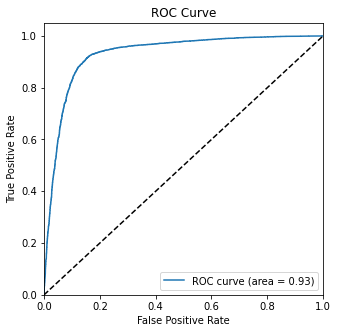

ROC: 92.97%
+-----+-----------------------------------------+----------+
|label|probability                              |prediction|
+-----+-----------------------------------------+----------+
|1    |[0.07502912424988464,0.9249708757501154] |1         |
|0    |[0.6824615599307816,0.3175384400692184]  |0         |
|1    |[0.036678551307462816,0.9633214486925372]|1         |
|1    |[0.07987129959833912,0.9201287004016608] |1         |
|0    |[0.9271754853363157,0.07282451466368434] |0         |
+-----+-----------------------------------------+----------+
only showing top 5 rows


DecisionTreeClassificationModel: uid=DecisionTreeClassifier_a4c6c203898b, depth=5, numNodes=25, numClasses=2, numFeatures=4
ROC:  0.88060209771953 	Precision recall:  0.8935752409103109


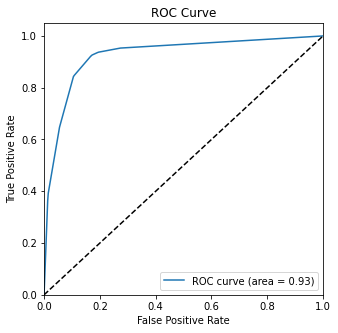

ROC: 92.55%
+-----+-----------------------------------------+----------+
|label|probability                              |prediction|
+-----+-----------------------------------------+----------+
|1    |[0.04156999226604795,0.958430007733952]  |1         |
|0    |[0.8184523809523809,0.18154761904761904] |0         |
|1    |[0.04156999226604795,0.958430007733952]  |1         |
|1    |[0.19846895378508647,0.8015310462149136] |1         |
|0    |[0.9418571564070948,0.058142843592905245]|0         |
+-----+-----------------------------------------+----------+
only showing top 5 rows


RandomForestClassificationModel: uid=RandomForestClassifier_f33197d267e5, numTrees=5, numClasses=2, numFeatures=4
ROC:  0.8815955932803344 	Precision recall:  0.8970720767232961


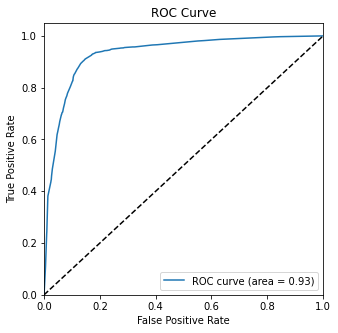

ROC: 93.15%
+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|1    |[0.06777725856009295,0.9322227414399071]|1         |
|0    |[0.5158512213518625,0.48414877864813766]|0         |
|1    |[0.06777725856009295,0.9322227414399071]|1         |
|1    |[0.3437724798609853,0.6562275201390148] |1         |
|0    |[0.9312988099919588,0.06870119000804112]|0         |
+-----+----------------------------------------+----------+
only showing top 5 rows



In [34]:
#resultados
sf1, sf2, ef = '\n\033[1m\033[106m\033[30m', '\n\033[1m\033[103m\033[30m', '\033[0m'
print('Resultados de las evaluaciones para las predicciones obtenidas con el conjunto de prueba')

#logistic regression
print(sf2, lr_cvmodel.bestModel, ef, sep='')
print('ROC: ', lr_metrics.areaUnderROC, '\tPrecision recall: ', lr_metrics.areaUnderPR)
print('ROC: {:.2%}'.format(plot_roc(lr_predic, lr_metrics, v=1)[0]))
# print(lr_metrics.getMetricsByThreshold().toPandas().describe().transpose())
lr_predic.withColumn('prediction', lr_predic['prediction'].cast(IntegerType())).select(['label','probability','prediction']).show(5, truncate=False)

#decision trees
print(sf2, dt_cvmodel.bestModel, ef, sep='')
print('ROC: ', dt_metrics.areaUnderROC, '\tPrecision recall: ', dt_metrics.areaUnderPR)
print('ROC: {:.2%}'.format(plot_roc(dt_predic, dt_metrics, v=1)[0]))
# print(dt_metrics.getMetricsByThreshold().toPandas().describe().transpose())
dt_predic.withColumn('prediction', dt_predic['prediction'].cast(IntegerType())).select(['label','probability','prediction']).show(5, truncate=False)

#random forrest
print(sf2, rf_cvmodel.bestModel, ef, sep='')
print('ROC: ', rf_metrics.areaUnderROC, '\tPrecision recall: ', rf_metrics.areaUnderPR)
print('ROC: {:.2%}'.format(plot_roc(rf_predic, rf_metrics, v=1)[0]))
# print(rf_metrics.getMetricsByThreshold().toPandas().describe().transpose())
rf_predic.withColumn('prediction', rf_predic['prediction'].cast(IntegerType())).select(['label','probability','prediction']).show(5, truncate=False)

---

## Conclusiones

  * Se realizó la carga, preprocesamiento y almacenamiento en base de datos de un conjunto de datos con casi 40 mil observaciones y 4 columnas numéricas de atributos, más una columna binaria de clases.

  * A partir del conjunto de datos almacenado se realizó una separación para entrenamiento y prueba con una relación 70/30, para luego aplicar un proceso de aprendizaje automático supervisado utilizando 3 modelos de clasificación: Regresión logística, Árboles de decisión y Bosques aleatorios.

  * El entrenamiento de los modelos fue evaluado a través de la técnica de validación cruzada K-Folds y utlizando diferentes parametrizaciones en cada modelo por medio de una grilla paramétrica. Con esto los resultados no solo permiten estimar la habilidad de cada modelo, sino también cuál de todas las combinaciones paramétricas resultó mejor para cada uno.

  * Los resultados de la evaluación en entrenamiento, utilizando 5 Folds, dan un mejor resultado para el modelo de **Regresión logística con un 93%**, seguido del modelo de **Bosques aleatorios con un 91%**. Además se obtuvieron los tiempos de ejecución para cada uno.
  
  * A continuación se muestran los tiempos de ejecución para la fase de entrenamiento para cada modelo, todos realizados en el mismo ambiente y con el mismo conjunto de datos.

        Regresión logística
        CPU times: user 1.08 s, sys: 250 ms, total: 1.33 s
        Wall time: 34.4 s
        Árboles de decisión
        CPU times: user 1.09 s, sys: 240 ms, total: 1.33 s
        Wall time: 26.1 s
        Bosques aleatorios
        CPU times: user 2.5 s, sys: 524 ms, total: 3.03 s
        Wall time: 46.9 s

  * Por otra parte, se ejecutó una etapa de evaluación con el conjunto de prueba utilizando el módulo de BinaryClassificationMetrics de pyspark.mllib, el cual permite comparar los resultados de las predicciones de cada modelos con las etiquetas correspondientes a cada observación.

  * Esta evaluación contempla el análisis tanto del **ROC** el cual muestra la compensación entre la tasa de verdaderos positivos y la tasa de falsos positivos, como del **Precision-Recall** que analiza la compensación entre la tasa positiva verdadera y el valor predictivo positivo; ambos utilizando diferentes umbrales de probabilidad para cada modelo.

  * Dado que las clases en el conjunto de datos están balanceadas se prefiere el uso del ROC para efectos de decidir cuál de los 3 modelos aporta mejor pronóstico probabilístico. En este caso el modelo de Bosques aleatorios brinda un mejor pronóstico con un resultado del 93.15%, el cual está ligeramente por encima del modelo de Regresión logística que alcanza un 92.97%. Sin embargo, este último se logró entrenar en un menor tiempo, por lo que su rendimiento final es mejor en comparación con el modelo de RF.

  * Cabe destacar que el modelo de Árboles de decisión alcanzó un resultado muy similar a los otros modelos y en un tiempo de ejecución mucho menor.

  * El proceso y los resultados se condideran satisfactorios.
  
  * Este trabajo permite mostrar de forma general la ruta que sigue un científico de datos desde la carga inicial de datos, hasta las etapas finales de predicción-evaluación y demuestra como la gran mayoría de los esfuerzos y recursos se centran en la fase de preprocesamiento. Como se dice usualmente, si se alimenta basura se obtendrá basura, de modo tal que los mejores modelos, configurados con los mejores parámetros, obtendrán terribles resultados si se alimentan de forma incorrecta.

---

# Código para generar HTML/PDF

In [16]:
# %%capture
# #opción #1 html
# !pip install nbconvert
# !sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-latex-recommended
# !pip install nb_pdf_template
# !python -m nb_pdf_template.install
# !pip install -U notebook-as-pdf
# !jupyter nbconvert --to html BIGDATA_07_2021_Tarea3_ESV.ipynb #--template classic

# #opción #2 pdf
# !wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
# from colab_pdf import colab_pdf
# colab_pdf('.ipynb')